In [35]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "Data/training_set"
eval_dir = "Data/test_set"

In [36]:
#Helper function to load images from given directories
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [37]:
import keras

uniq_labels = sorted(os.listdir(train_dir))
# print(uniq_labels)
images, labels = load_images(directory = train_dir)
# print(labels) 77 images of each label

# if uniq_labels == sorted(os.listdir(eval_dir)):
#     X_eval, y_eval = load_images(directory = eval_dir)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

# eval_n = len(X_eval)
# print("Number of evaluation images: ", eval_n)

Total number of symbols:  3
Number of training images:  184
Number of testing images:  47


In [39]:
print(y_train[0])
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
# y_eval = keras.utils.to_categorical(y_eval)
print(y_train[0])
print(len(y_train))

0
[1. 0. 0.]
184


In [51]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')


In [52]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [60]:
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=3, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [62]:
#fit the model
#it will take some time to train
history = model.fit(X_train, y_train, epochs =5,batch_size=3,validation_data=(X_test,y_test))

Epoch 1/5
62/62 [==============================] - 5s 74ms/step - loss: 8.5076 - accuracy: 0.6974 - val_loss: 0.2699 - val_accuracy: 0.9787
Epoch 2/5
62/62 [==============================] - 4s 68ms/step - loss: 0.3441 - accuracy: 0.9815 - val_loss: 0.2642 - val_accuracy: 0.9574
Epoch 3/5
62/62 [==============================] - 4s 68ms/step - loss: 2.4178 - accuracy: 0.9485 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
62/62 [==============================] - 4s 70ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/5
62/62 [==============================] - 4s 70ms/step - loss: 0.6189 - accuracy: 0.9588 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [63]:
# Saving the model of vgg16
model.save('model_vgg16.h5')

In [64]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %


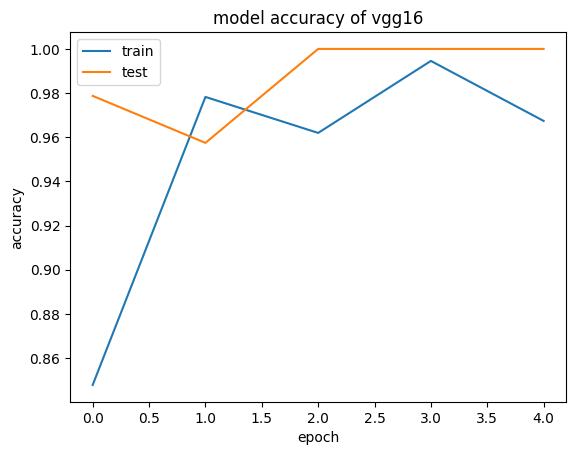

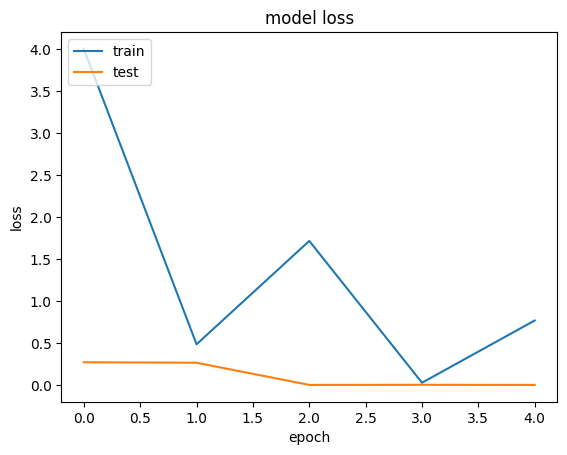

In [65]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

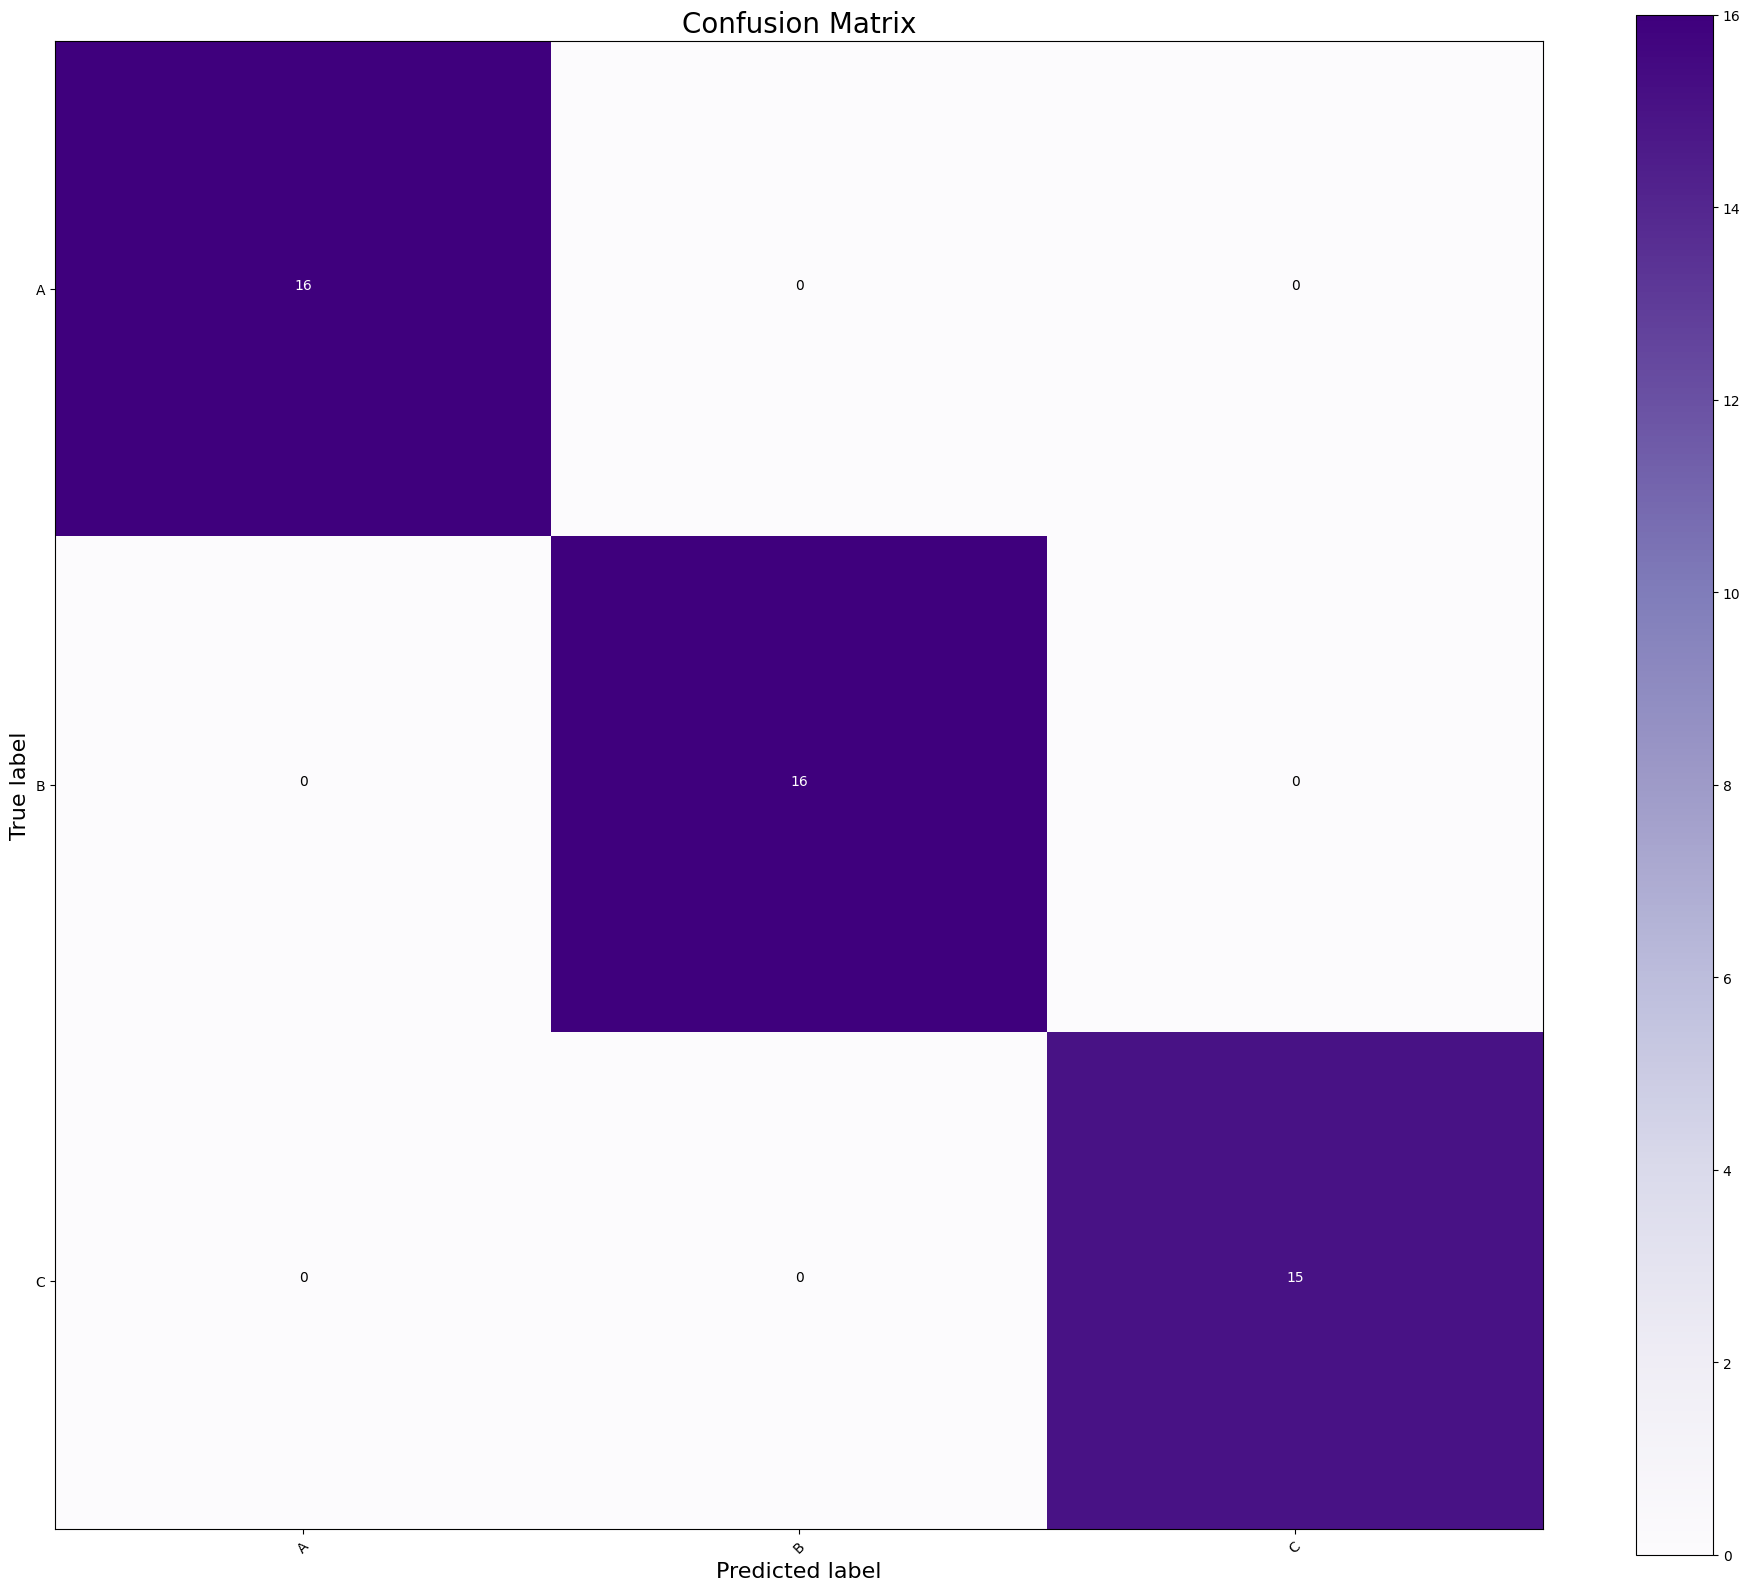

In [66]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)